# Example: The RecModel package for implicit feedback

## Get the Data
In the following we test the SLIM model based on the Netflix dataset. As all models in the RecModel package use csr matrix as input, we need to download the Netflix dataset and convert it to csr.

Fortunately, I created a small repo that does exatly that: [Data](https://github.com/titoeb/ImplicitFeedback).

Do the following steps to create the Netflix dataset:

* Clone the Repository
    ```
    git clone https://github.com/titoeb/ImplicitFeedback
    ```

* Change into the repository:
    ```
    cd ImplicitFeedback
    ```
* Allow execution of the Bash Script:
    ```
    chmod +x Create_Data
    ```

* Execute the Bash Script. This may take some time as the Netflix, ML20 and Million Song Dataset is download.
    ```
    ./Create_Data
    ```

* Now the data is downloaded. To create the CSR matrix run the Netflix.py script.
    ```
    python Netflix.py
    ```
* Now you simply copy the Netflix.npz file into the data folder in your directory of the RecModel Package. You can delete the Implicit Feedback Data folder.


To import the data, fit the SLIM model and analyze the results we need the following packages:

In [1]:
import scipy.sparse
import numpy as np
import RecModel
import matplotlib.pyplot as plt
plt.style.use('ggplot')

The Recmodel package implements the following models:

* [Neighbor](https://dl.acm.org/doi/10.1145/371920.372071): RecModel.Neighborhood

* [SLIM](https://dl.acm.org/doi/10.1109/ICDM.2011.134): RecModel.SLIM

* [VAE](https://dl.acm.org/doi/abs/10.1145/3178876.3186150): RecModel.VAE

* [EASE](https://dl.acm.org/doi/abs/10.1145/3308558.3313710): RecModel.EASE

* [WMF](https://dl.acm.org/doi/10.1109/ICDM.2008.22): RecModel.WMF

* [RecWalk](https://dl.acm.org/doi/abs/10.1145/3289600.3291016): RecModel.RecWalk

All these models have different hyper parameters, for more details take a look in the Documentation of the individual models.

Before we fit any models we need to load the netflix data. To speed up computation, we only use the first 10000 users and the first 2500 items.

In [2]:
netflix_data = scipy.sparse.load_npz('data/Netflix.npz')[:10000, :2500]

num_users, num_items = netflix_data.shape

And split it into train and test:

In [3]:
train_data, test_data = RecModel.train_test_split_sparse_mat(netflix_data)

In this tutorial, first we are going to fit a baseline model, that predicts random items to users. Afterwards, we are going to fit the SLIM model, a regularized, linear model model.

Let's start with the Baseline!

The Naive Baseline only samples random items for every user. Therefore it does not need be trained.

In [4]:
naive_model = RecModel.NaiveBaseline(num_items=num_items)

Evaluate the recall@4, recall@10, recall@20 and recall@50 performance based on 1000 random items for each user:

In [5]:
naive_model_performance = naive_model.eval_topn(test_mat=test_data, topn = np.array([4, 10, 20, 50]), rand_sampled=1000)

In [6]:
print(naive_model_performance)

{'Recall@4': 0.0061108684, 'Recall@10': 0.014061233, 'Recall@20': 0.026657106, 'Recall@50': 0.06728191}


Random sampling items of items only gets us a recall@50 of about 6.7 percent (as is reasonable when sampling 50 out of 1001 items). Let's use the SLIM model to improve the performance!

In [7]:
slim_model = RecModel.SLIM(num_items=num_items, num_users=num_users)

The SLIM model is a  model-based collaborative filtering recommender. Therefore it needs to be trained on past interaction data. Unfortunately, the SLIM model is expensive to train and would need about an hour of training based on the full netlix dataset. To get more information about the status during training, set the verbose parameter to True! Additionally, the model has the hyper parameters alpha, l1_ratio, max_iter and tolerance. I set them to values that worked good on other datasets. To improve performance you should tune them to the netflix dataset.

In [8]:
slim_model.train(X=train_data, alpha=4.427181, l1_ratio=0.318495, max_iter=27, tolerance=0.006841, cores=8, verbose=False)

After we trained the model, we can check its performance on the test dataset:

In [9]:
slim_model_performance = slim_model.eval_topn(test_mat=test_data, topn = np.array([4, 10, 20, 50]), rand_sampled=1000)

In [10]:
print(slim_model_performance)

{'Recall@4': 0.17955354, 'Recall@10': 0.32839683, 'Recall@20': 0.49108312, 'Recall@50': 0.71409863}


The Slim model already gets a recall@4 performance of about 17.6 percent and a recall@50 performance of 71.4 percent. Finally some solid numbers!

Finally, we might be interested into more qualitative information about the model performance. Therefore,  we compute the recommendation frequencies given the top 4 recommendation for all users:

In [11]:
recommendation_frequencies = RecModel.test_coverage(slim_model, train_data, topN=4)

Unfortunately, the model does only have a cataloge coverage of about 4.6 percent:

In [12]:
(recommendation_frequencies > 0).mean()

0.0457

We can also plot the frequencies of the most recommended items:

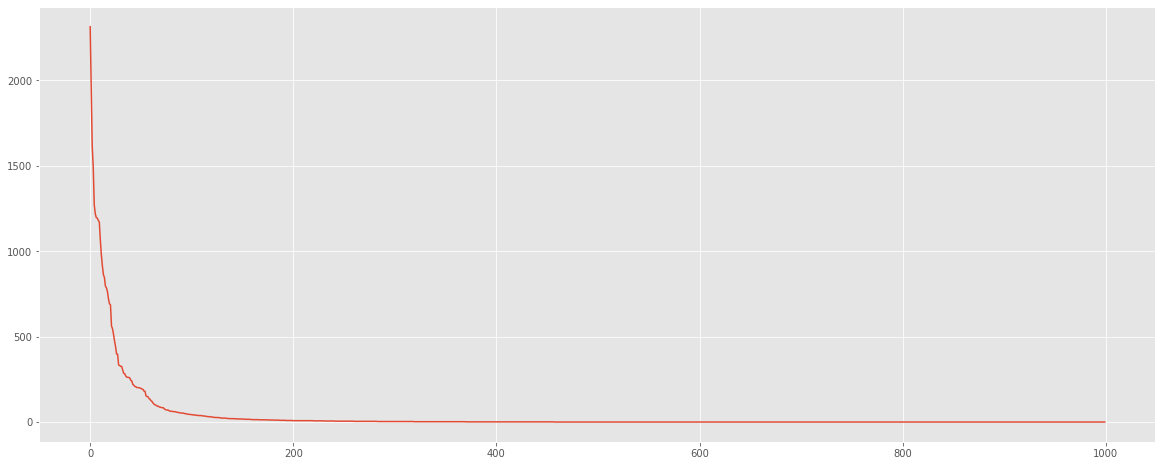

In [13]:
n_items_to_plot = 1000

sorted_recommendation_frequencies = np.sort(recommendation_frequencies)[::-1]

fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(np.arange(0, n_items_to_plot), sorted_recommendation_frequencies[:n_items_to_plot])
